<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Загрузка-данных" data-toc-modified-id="1.-Загрузка-данных-1">1. Загрузка данных</a></span></li><li><span><a href="#2.-Умножение-матриц" data-toc-modified-id="2.-Умножение-матриц-2">2. Умножение матриц</a></span></li><li><span><a href="#3.-Алгоритм-преобразования" data-toc-modified-id="3.-Алгоритм-преобразования-3">3. Алгоритм преобразования</a></span></li><li><span><a href="#4.-Проверка-алгоритма" data-toc-modified-id="4.-Проверка-алгоритма-4">4. Проверка алгоритма</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5">Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6">Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Необходимо защитить данные клиентов страховой компании «Хоть потоп». Разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

План работы:
1. Загрузить и изучить данные.
2. Ответить на вопрос и обосновать решение.
Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)
3. Предложить алгоритм преобразования данных для решения задачи. Обосновать, почему качество линейной регрессии не поменяется.
4. Запрограммировать этот алгоритм, применив матричные операции. Проверить, что качество линейной регрессии из sklearn не отличается до и после преобразования. Применить метрику R2.

## 1. Загрузка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\\dataset_praktikum/insurance.csv') # чтение и сохранение файла

Напишем функцию для exploratory data analysis.

In [14]:
def exploration(data):
    '''
    функция EDA
    параметр - исследуемый dataframe
    return - общая информация о dataframe
    '''
    print('\033[1m Основная информация \033[0m')
    print()
    data.info()
    print(100*'*')
    print()
    print('\033[1m Первые пять строк \033[0m')
    display(data.head())
    print(100*'*')
    print()
    print('\033[1m Проверка на дубликаты \033[0m')
    print('Количество дубликатов = ', data.duplicated().sum())
    print(100*'*')
    print()
    print('\033[1m Основная статистическая информация \033[0m')
    display(data.describe().T)
    print(100*'*')
    print()
    print('\033[1m Распределение данных (гистограммы) \033[0m')
    data.hist(bins=50, figsize=(20,15), edgecolor='#76d2db', linewidth=2)
    plt.show()

 Основная информация 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                4847 non-null   int64  
 1   Возраст            4847 non-null   float64
 2   Зарплата           4847 non-null   float64
 3   Члены семьи        4847 non-null   int64  
 4   Страховые выплаты  4847 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 227.2 KB
****************************************************************************************************

 Первые пять строк 


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


****************************************************************************************************

 Проверка на дубликаты 
Количество дубликатов =  0
****************************************************************************************************

 Основная статистическая информация 


,count,mean,std,min,25%,50%,75%,max
Пол,4847.0,0.498453,0.500049,0.0,0.0,0.0,1.0,1.0
Возраст,4847.0,31.023932,8.487995,18.0,24.0,30.0,37.0,65.0
Зарплата,4847.0,39895.811842,9972.953985,5300.0,33200.0,40200.0,46600.0,79000.0
Члены семьи,4847.0,1.203425,1.098664,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,4847.0,0.152259,0.468934,0.0,0.0,0.0,0.0,5.0


****************************************************************************************************

 Распределение данных (гистограммы) 


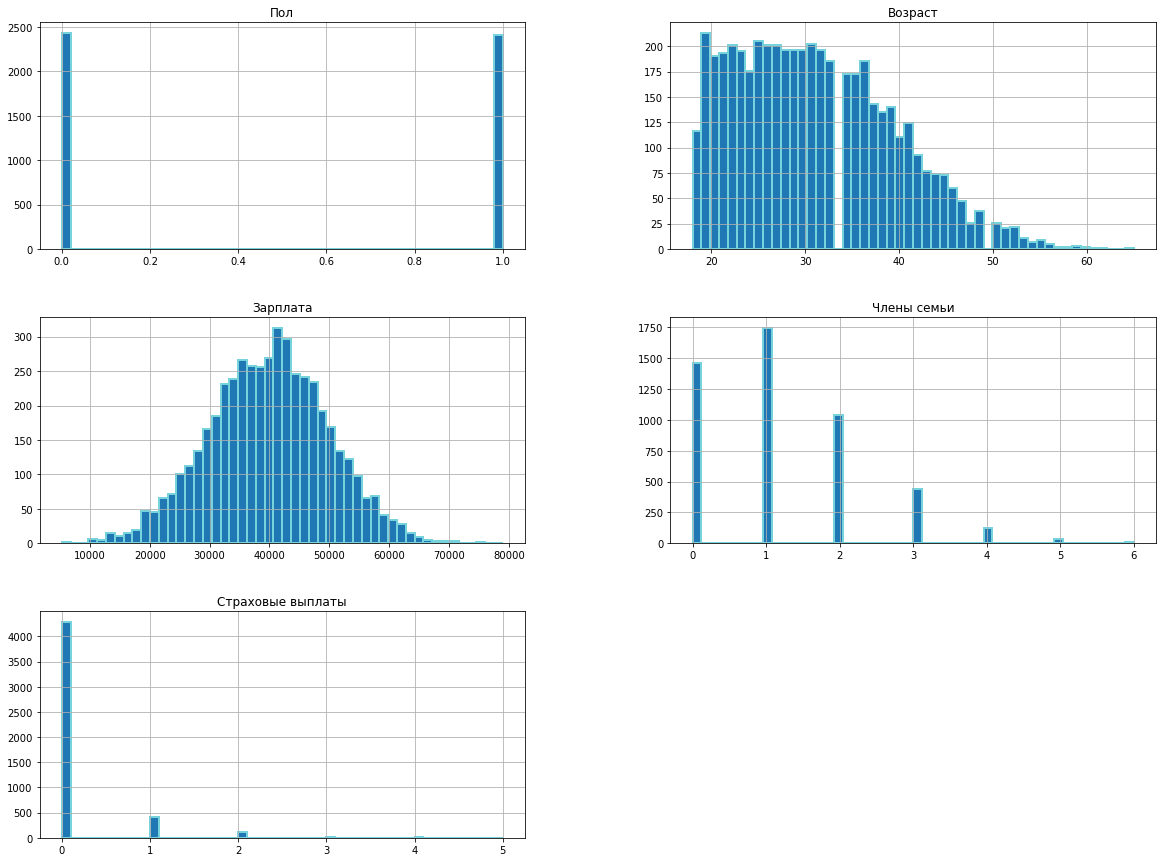

In [15]:
exploration(df)

In [5]:
df.drop_duplicates(subset=None, keep='first', inplace=True) #удалим дубликаты
#df = df.reset_index()

В целом данные представлены в хорошем качестве. Обнаружено небольшое количество дубликатов.

## 2. Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
(Xw-y)^2\rightarrow min_w
$$
$$
(Xw-y)(Xw-y)^T\rightarrow min_w
$$
$$
X^TXw = X^Ty
$$
$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Если в задаче линеной регрессии $a = Xw$ умножить $X (m, n)$ на обратимую матрицу $Z$, размерности $(n, n)$, то при вычислении весов $w = (X^T X)^{-1} X^T y$ предсказания $a$ не изменятся.

**Обоснование:** Для доказательства подставим вместо $X \rightarrow XZ$

$$
a_{new} = XZw_{new}
$$

$$
w_{new} = ((XZ)^T XZ)^{-1}(XZ)^T y
$$
подставим $w_{new}$ в $a_{new}$ и преобразуем:

$a_{new} = X Z ((XZ)^T XZ)^{-1}(XZ)^T y = \\X Z (Z^TX^T XZ)^{-1}Z^T X^T y = \\X Z (X^TXZ)^{-1} (Z^T)^{-1} Z^T X^T y = \\X Z Z^{-1}(X^TX)^{-1} (Z^T)^{-1} Z^T X^T y = \\X E (X^TX)^{-1} E  X^T y = \\X (X^TX)^{-1} X^T y =  X w$

Для раскрытия скобок и преобразований использованы свойства матриц:

Транспонированное произведение матриц равно произведению транспонированных матриц, взятых в обратном порядке:
 - $ (AB)^T = B^T A^T $

Произведение матриц ассоциативно:
 - $ (AB)C = A(BC) $

Свойства обратных и единичных матриц:
 - $ AA^{-1} = A^{-1}A = E $
 - $ AE = EA = A $
 - $ (AB)^{-1} = B^{-1}A^{-1} $

## 3. Алгоритм преобразования

**Алгоритм**

1. Генерируем случайную матрицу Z (n,n), n - число кодируемых признаков.
2. Проверяем ее на обратимость.
3. Вычисляем обратную матрицу Z.
4. Умножаем исходную матрицу X на матрицу Z.

**Обоснование**

Согласно доказательству выше, при умножении матрицы признаков X на произвольную, обратимую матрицу Z, качество линейной регрессии останется неизменным.  
Пространство признаков можно преобразовать к первоначальному виду, умножив на обратную матрицу.  
$ (XZ)Z^{-1} = X(ZZ^{-1}) = XE = X $

## 4. Проверка алгоритма

Разделим наши данные на признаки и целевую переменную

In [6]:
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

Вычислим r2 линейной регрессии на исходных данных.

In [7]:
model = LinearRegression()
round(cross_val_score(model, features, target, scoring='r2').mean(),4)

0.4278

Изменим признаки в соответствии с алгоритмом.  
Создадим случайную матрицу.

In [8]:
n = features.shape[1]
np.random.seed(20)
Z = np.random.normal(size=(n,n))
Z

array([[ 0.88389311,  0.19586502,  0.35753652, -2.34326191],
       [-1.08483259,  0.55969629,  0.93946935, -0.97848104],
       [ 0.50309684,  0.40641447,  0.32346101, -0.49341088],
       [-0.79201679, -0.84236793, -1.27950266,  0.24571517]])

Убедимся, что наша матрица обратима.

In [9]:
np.linalg.inv(Z)

array([[ 0.21152388, -0.53786562, -0.12028991, -0.36622811],
       [-1.13011632,  0.47439007,  5.08231316,  1.31734562],
       [ 0.54426017, -0.01104771, -3.29519731, -1.47061355],
       [-0.35838626, -0.16491936, -0.1233449 , -0.25241849]])

Закодируем данные

In [10]:
encoded_features = features@Z

Вычислим r2 линейной регрессии на кодированных данных.

In [11]:
model = LinearRegression()
round(cross_val_score(model, encoded_features, target, scoring='r2').mean(),4)

0.4278

Качество модели не изменилось.

In [12]:
features.head()

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


Преобразуем наши данные в первоначальный вид.

In [13]:
round(encoded_features@np.linalg.inv(Z)).head()

,0,1,2,3
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


Данные восстановлены.

Мы провели реализацию алгоритма кодирования признаков и убедились, что данный алгоритм никак не влияет на качество модели - данный инструмент можно использовать в дальнейшем для кодирования признаков.

## Общий вывод

Цель проекта - защитить данные клиентов страховой компании.

Решение - предложен алгоритм преобразования данных путем матричного умножения.  
Доказано, что при таком кодировании данных предсказания модели линейной регрессии не изменятся.